<a href="https://colab.research.google.com/github/ricardoV94/mbmlbook/blob/master/MBML_Chapter_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 2

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
plt.rcParams.update({'font.size': 16})

In [0]:
try:
    import arviz
except ImportError:
    !pip install arviz

In [0]:
import logging
logger = logging.getLogger('pymc3')
logger.propagate = False
logger.setLevel(logging.ERROR)



---


## 2.2 Testing out the model 

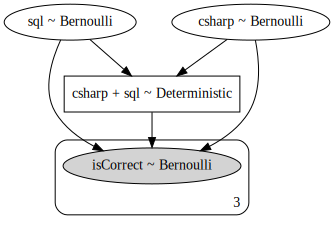

In [4]:
with pm.Model() as model1:
    # This allowss data to be inputed after the model is created
    observed_answers = theano.shared(np.array([1,0,0]))
    
    csharp = pm.Bernoulli('csharp', p=0.5)
    sql = pm.Bernoulli('sql', p=0.5)
    
    # AND function emulated by multiplying the two variables
    # Equivalent to pm.Deterministic('csharp + sql', csharp * sql)
    both = pm.Deterministic('csharp + sql', tt.prod([csharp, sql]))

    noise = pm.math.switch(tt.stack([csharp, sql, both]), .9, .2)
    isCorrect = pm.Bernoulli('isCorrect', noise, shape=3, observed=observed_answers)
                
pm.model_to_graphviz(model1)

In [0]:
def compute_mean(trace, show=4):
    trace_means = []
    for i, var in enumerate(trace.varnames):
        if i==show:
            break
        trace_means.append(np.round(trace[var].mean(),3))
    return trace_means

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))


[0.803, 0.037, 0.012]


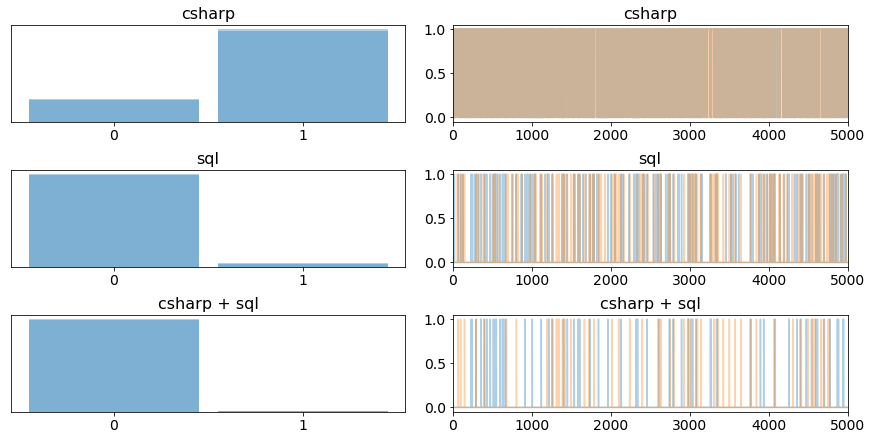

In [6]:
with model1:         
    observed_answers.set_value([1, 0, 0])
    trace = pm.sample(5000, progressbar=False)
    
pm.traceplot(trace)
print(compute_mean(trace))

In [7]:
possible_answers = [[0,0,0], [1,0,0], [0,1,0], [1,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,1]]
possible_traces = []
for answers in tqdm(possible_answers):
    with model1:         
        observed_answers.set_value(answers)
        trace = pm.sample(2000, progressbar=False)
    possible_traces.append(trace)

100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


In [8]:
for answers, trace in zip(possible_answers, possible_traces):
    print(f'Answers: {answers} -> Prob: {compute_mean(trace)}')

Answers: [0, 0, 0] -> Prob: [0.09, 0.106, 0.001]
Answers: [1, 0, 0] -> Prob: [0.801, 0.033, 0.011]
Answers: [0, 1, 0] -> Prob: [0.034, 0.798, 0.011]
Answers: [1, 1, 0] -> Prob: [0.576, 0.556, 0.204]
Answers: [0, 0, 1] -> Prob: [0.149, 0.141, 0.051]
Answers: [1, 0, 1] -> Prob: [0.863, 0.319, 0.304]
Answers: [0, 1, 1] -> Prob: [0.322, 0.87, 0.308]
Answers: [1, 1, 1] -> Prob: [0.94, 0.95, 0.901]




---

## 2.3 Loopiness 

(Not a problem with sampling-based inference)

In [0]:
with pm.Model() as model2:  
    answers = [1,0,0,0]

    csharp = pm.Bernoulli('csharp', p=0.5)
    sql = pm.Bernoulli('sql', p=0.5)
    both1 = pm.Deterministic('csharp + sql 1', tt.prod([csharp, sql]))
    both2 = pm.Deterministic('csharp + sql 2', tt.prod([csharp, sql]))
    
    noise = pm.math.switch(tt.stack([csharp, sql, both1, both2]), .9, .2)

    isCorrect = pm.Bernoulli('isCorrect', noise, shape=4, observed=answers)

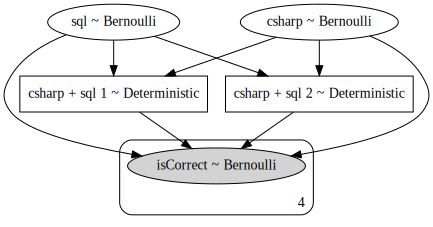

In [10]:
pm.model_to_graphviz(model2)

In [11]:
with model2:
    trace = pm.sample(5000, progressbar=False)
print(f'Answers: {answers} -> Prob: {compute_mean(trace)}')

Answers: [1, 0, 0, 0] -> Prob: [0.798, 0.024, 0.002, 0.002]




---

## 2.4 Moving to real data 

### Visualization

In [0]:
def plot_grid(data, ylabel, xlabel, kwargs={'cmap':'gray', 'vmin':-.3}, create_fig=True):
    
    if create_fig:
        plt.figure(figsize=(14,6))
    extent = (0, data.shape[1], data.shape[0], 0)
    plt.imshow(data, extent=extent, aspect='equal', **kwargs)
    
    for i in range(data.shape[1]):
        plt.axvline(i, color='k')
    for i in range(data.shape[0]):
        plt.axhline(i, color='k')
        
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
        
def plot_colorful_grid(data, ylabel, xlabel):
    skills = skills_ground
    answers = np.array(np.copy(data.T), dtype=np.float)

    for i in range(skills.shape[1]): 
        skill=np.where(skills[:, i]==True)[0]

        for j in range(answers.shape[1]):
            answers[:,j][skill] = i
               
    answers[data.T == True] = np.nan
    
    # Shared skills are overriden. 
    # There seems to be no straigtforward solution if using matplotlib imshow()

    plot_grid(answers.T, ylabel, xlabel, kwargs={'cmap':'Dark2', 'vmax':8})
    cbar = plt.colorbar()
    cbar.set_ticks(np.arange(7)+.5);
    cbar.ax.set_yticklabels(['Core', 'OOP', 'Life Cycle', 'Web Apps', 'Desktop Apps', 'SQL', 'C#']);
   
    
def plot_multiple_grids(data, ylabel, xlabels):
    n = len(data)
    fig, ax = plt.subplots(1,n, figsize=(n*3.5,6))
    
    for i, (datum, xlabel) in enumerate(zip(data, xlabels), 1):
        plt.subplot(1,n,i)
        plot_grid(datum, ylabel, xlabel, create_fig=False)  
        if i < n:
            plt.title(f'r = {st.pearsonr(datum.ravel(), data[-1].ravel())[0]:.3f}')

In [0]:
url1 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch2_skills.csv'
url2 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch2_answers.csv'
url3 = 'https://raw.githubusercontent.com/ricardoV94/mbmlbook/master/data/Ch2_skills_self.csv'
df1 = pd.read_csv(url1, header=None)
df2 = pd.read_csv(url2, header=None)
df3 = pd.read_csv(url3, header=None)

skills_ground = df1.values
given_answers = df2.values.T
true_skills = df3.values.T

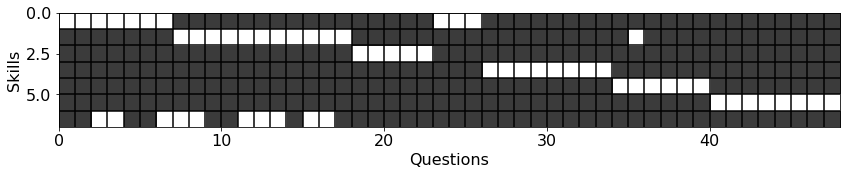

In [14]:
plot_grid(skills_ground.T, 'Skills', 'Questions')

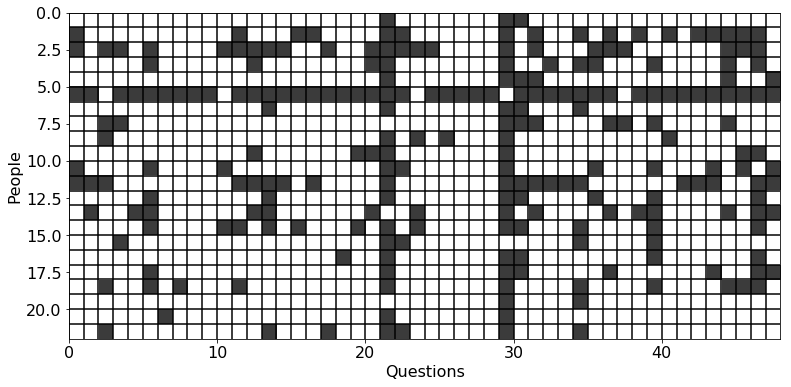

In [15]:
plot_grid(given_answers, 'People', 'Questions')

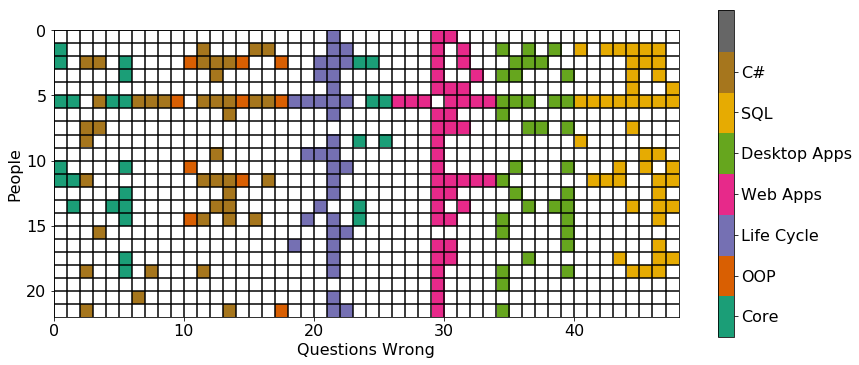

In [16]:
plot_colorful_grid(given_answers, 'People', 'Questions Wrong')


### Model

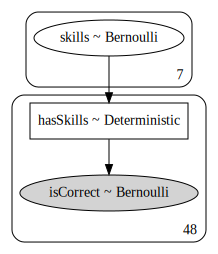

In [17]:
def get_relevant_skills():
    # Ugly hack to combine questions that rely in one or more skills under the same function
    max_shared_skills = skills_ground.sum(axis=1).max()
    relevant_skills = np.zeros((skills_ground.shape[0], max_shared_skills), dtype=np.int)
    for i, question in enumerate(skills_ground):
        relevant = np.where(question == True)[0]
        relevant_skills[i] = relevant
    return relevant_skills

with pm.Model() as model3:    
    relevant_skills = get_relevant_skills()
    observed_answers = theano.shared(given_answers[0])

    skills = pm.Bernoulli('skills', 0.5, shape=7) 
    # Ugly hack is used here
    hasSkills = pm.Deterministic('hasSkills', tt.prod(skills[relevant_skills], axis=1))  

    noise = pm.math.switch(hasSkills, .9, .2)
    isCorrect = pm.Bernoulli('isCorrect', noise, shape=48, observed=observed_answers)
    
pm.model_to_graphviz(model3)

In [18]:
inferred_skills = np.zeros((22,7))

for i, answers in enumerate(tqdm(given_answers)):    
    with model3:     
        observed_answers.set_value(answers)
        trace = pm.sample(draws=500, progressbar=False)
        
    inferred_skills[i] = trace['skills'].mean(axis=0)

100%|██████████| 22/22 [00:17<00:00,  1.24it/s]


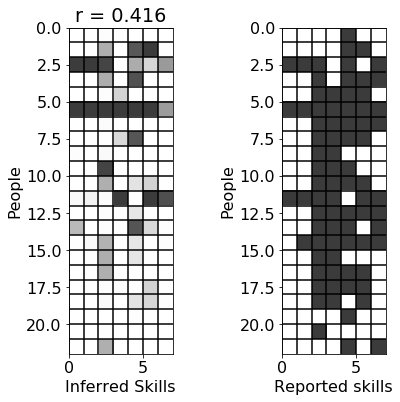

In [19]:
plot_multiple_grids([inferred_skills, true_skills], 'People', ['Inferred Skills', 'Reported skills'])



---


##  2.5 Diagnosing the problem

###  Checking the inference algorithm 

In [0]:
with model3:
    sample = pm.sample_prior_predictive(22)

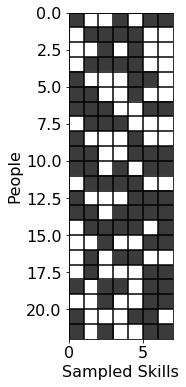

In [21]:
plot_grid(sample['skills'], 'People', 'Sampled Skills')

In [22]:
inferred_skills_sim = np.zeros((22,7))

for i, answers in enumerate(tqdm(sample['isCorrect'])):  
    with model3:     
        observed_answers.set_value(answers.astype(np.bool))
        trace = pm.sample(draws=500, progressbar=False)
        
    inferred_skills_sim[i] = trace['skills'].mean(axis=0)

100%|██████████| 22/22 [00:17<00:00,  1.26it/s]


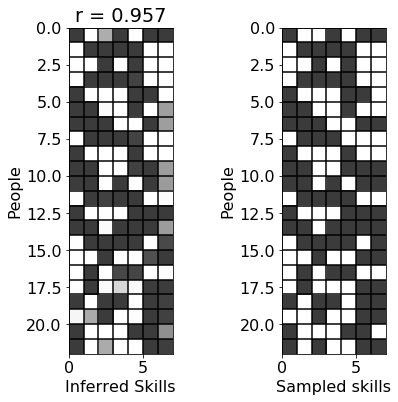

In [23]:
plot_multiple_grids([inferred_skills_sim, sample['skills']], 'People', ['Inferred Skills', 'Sampled skills'])

 ### Working out what is wrong with the model 
 
 Setting the skills to the ground truth (self-reported skills)

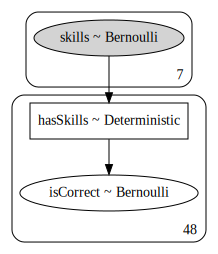

In [24]:
with pm.Model() as model4:
    # Need new model due to setting skills to observed now...
    # Not sure if this could have been done while perserving model3
    
    relevant_skills = get_relevant_skills()    
    # New variable
    reported_skills = theano.shared(true_skills[0].astype(np.int))
    #observed_answers = theano.shared(given_answers[0])

    skills = pm.Bernoulli('skills', 0.5, shape=7, observed=reported_skills) 
    hasSkills = pm.Deterministic('hasSkills', tt.prod(skills[relevant_skills], axis=1))  
    noise = pm.math.switch(hasSkills, .9, .2)
    isCorrect = pm.Bernoulli('isCorrect', noise, shape=48) #observed=observed_answers)
    
pm.model_to_graphviz(model4)

In [25]:
inferred_isCorrect = np.zeros((22,48))

for i, reported in enumerate(tqdm(true_skills)):
    with model4:
        reported_skills.set_value(reported.astype(np.int))
        sample = pm.sample_prior_predictive(50)
    inferred_isCorrect[i] = sample['isCorrect'][0]

100%|██████████| 22/22 [00:00<00:00, 22.41it/s]


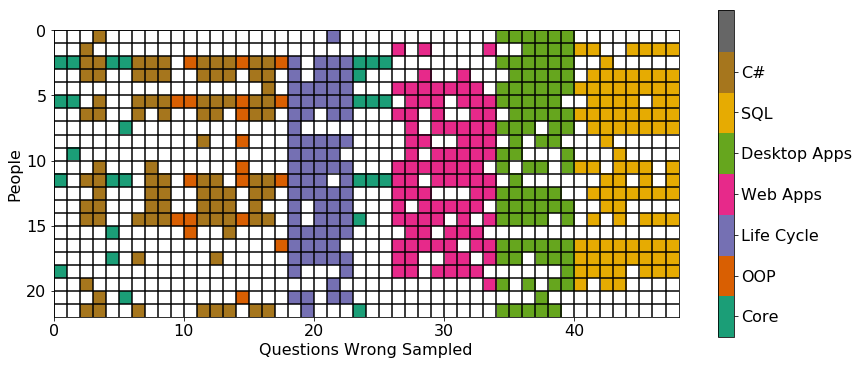

In [26]:
plot_colorful_grid(inferred_isCorrect , 'People', 'Questions Wrong Sampled')

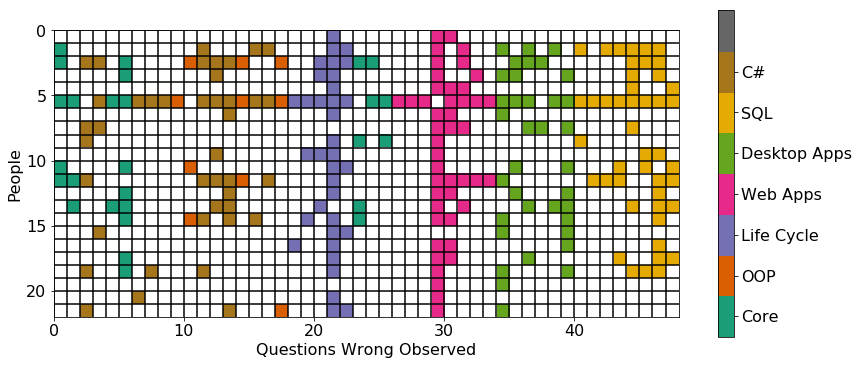

In [27]:
plot_colorful_grid(given_answers, 'People', 'Questions Wrong Observed')

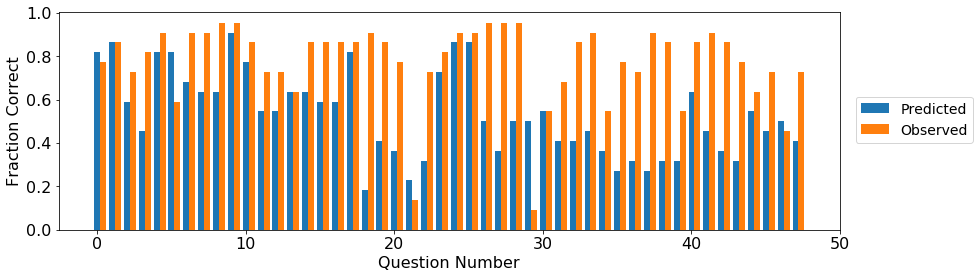

In [28]:
plt.figure(figsize=(14,4))
plt.bar(np.arange(48), inferred_isCorrect.mean(axis=0), width=0.4, label='Predicted')
plt.bar(np.arange(48)+.4, given_answers.mean(axis=0), width=0.4, label='Observed')
plt.legend(loc=(1.02,.4),fontsize=14)

plt.ylabel('Fraction Correct')
plt.xlabel('Question Number');



---

##  2.6 Learning the guess probabilities 

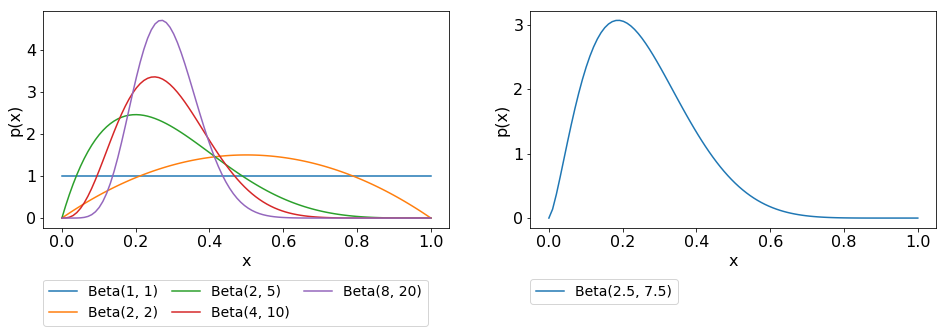

In [29]:
plt.figure(figsize=(16,4))
x = np.linspace(0,1, 100)

plt.subplot(121)
beta_params = [[1,1], [2,2], [2,5], [4,10], [8,20]]
for params in beta_params:
    plt.plot(x, st.beta.pdf(x, *params), label=f'Beta({params[0]}, {params[1]})')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend(fontsize=14, ncol=3, loc=(0,-.45), columnspacing=1)

plt.subplot(122)
params=[2.5, 7.5]
plt.plot(x, st.beta.pdf(x, *params), label=f'Beta({params[0]}, {params[1]})')
plt.ylabel('p(x)')
plt.xlabel('x')
plt.legend(fontsize=14, ncol=3, loc=(0,-.35), columnspacing=1)

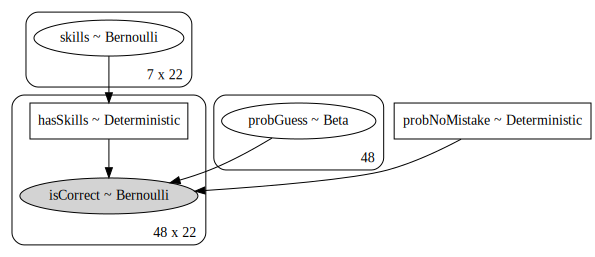

In [30]:
# Model must include all people and answers in order to jointly estimate the
# guess porabibility for each question (it only makes sense across participants)
with pm.Model() as model5:
    
    relevant_skills = get_relevant_skills()
        
    # Skills of each person are considered in the same model
    skills = pm.Bernoulli('skills', 0.5, shape=(7,22)) 
    hasSkills = pm.Deterministic('hasSkills', tt.prod(skills[relevant_skills], axis=1))  

    # New components of the model
    probGuess = pm.Beta('probGuess', alpha=2.5, beta=7.5, shape=48)
    probNoMistake = pm.Deterministic('probNoMistake', tt.constant(.9))
    
    # The probability of guessing each question is shared across participants
    noise = pm.math.switch(hasSkills, probNoMistake, probGuess[:, None])
    isCorrect = pm.Bernoulli('isCorrect', noise, shape=(48,22), observed=given_answers.T)
    
pm.model_to_graphviz(model5)

In [31]:
with model5:
    trace = pm.sample(draws=100*22)
inferred_skills_new = trace['skills'].mean(axis=0).T

100%|██████████| 2700/2700 [00:42<00:00, 63.80it/s]


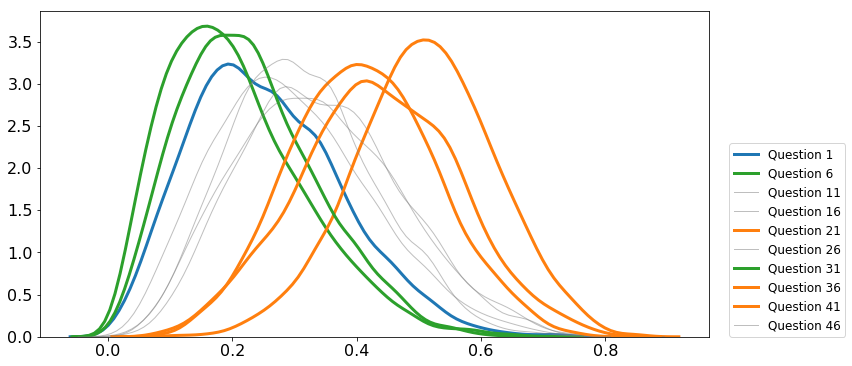

In [32]:
plt.figure(figsize=(12,6))
dt = {'highlight':[0,5,30,20,35,40],
      'equal':[0],
      'less':[5,30],
      'more': [20,35,40]}

for i in range(0,48,5):
    lw, alpha, c = 1, 0.5, 'gray'
    if i in dt['highlight']:
        lw, alpha, c = 3, 1, 'C0'
        if i in dt['more']:
            c = 'C1'
        elif i in dt['less']:
            c = 'C2'
            
    sns.distplot(trace['probGuess'][:,i], hist=False, kde_kws={'linewidth':lw, 'alpha':alpha, 'color':c}, label=f'Question {i+1}')
plt.legend(loc=(1.03,0), fontsize=12);

Text(0.5, 0, 'Question Number')

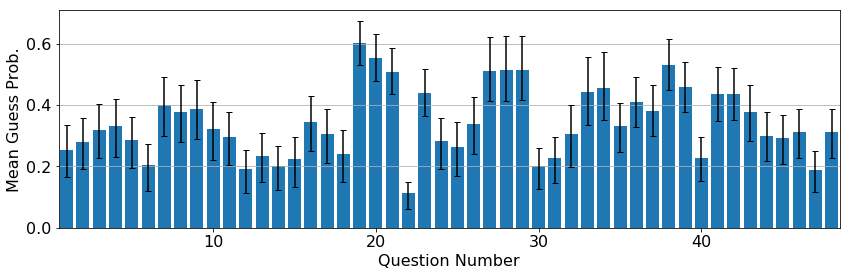

In [33]:
plt.figure(figsize=(14,4))

y = np.mean(trace['probGuess'], axis=0)
error = np.abs(np.percentile(trace['probGuess'], [25,75], axis=0) - y)

plt.bar(x=np.arange(1,49), height=y, yerr=error, capsize=3)
plt.grid(axis='y')
plt.xlim([.5,48.5])
plt.ylabel('Mean Guess Prob.')
plt.xlabel('Question Number')

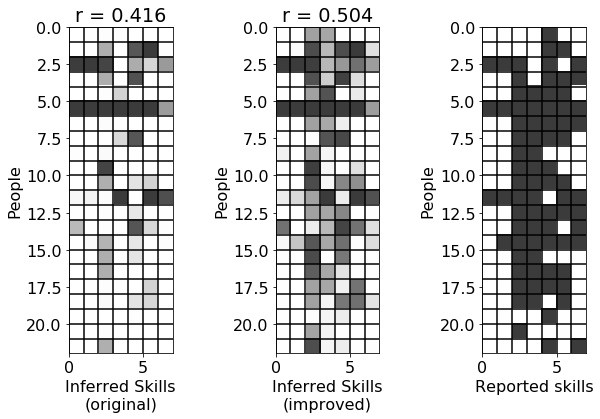

In [34]:
plot_multiple_grids([inferred_skills, inferred_skills_new, true_skills], 'People', ['Inferred Skills\n(original)', 'Inferred Skills\n(improved)', 'Reported skills'])

### Measuring Progress

#### Log Probability

In [0]:
def logProb(inferred, ground_truth):
    prob = np.zeros((22,7))
    prob[ground_truth == True]  = inferred[ground_truth == True ]
    prob[ground_truth == False] = 1-inferred[ground_truth == False]
    prob[prob==0] = 0.0001 # Hack needed to avoid exploding to -infinity
    return np.log(prob)

In [0]:
logProb_old = logProb(inferred_skills, true_skills)
logProb_new = logProb(inferred_skills_new, true_skills)

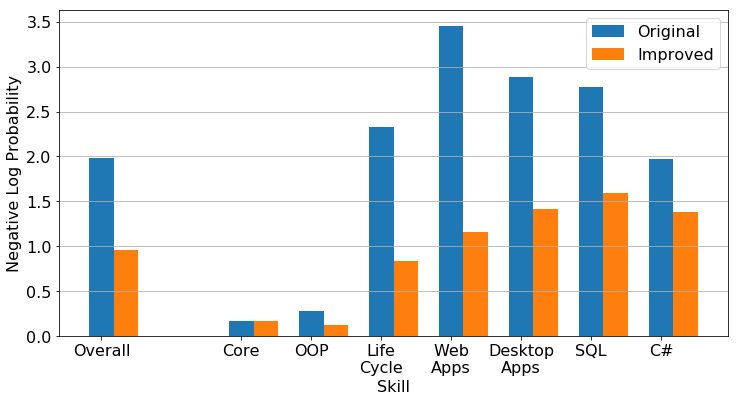

In [37]:
plt.figure(figsize=(12,6))
plt.bar(x=-2, height=-logProb_old.mean(), width=.35, color='C0', label='Original')
plt.bar(x=-2+.35, height=-logProb_new.mean(), width=.35, color='C1', label='Improved')

plt.bar(x=np.arange(7), height=-logProb_old.mean(axis=0), width=.35, color='C0')
plt.bar(x=np.arange(7)+.35, height=-logProb_new.mean(axis=0), width=.35, color='C1')
plt.grid(axis='y')

plt.xticks([-2,0,1,2,3,4,5,6], ['Overall', 'Core', 'OOP', 'Life\nCycle', 'Web\nApps', 'Desktop\nApps', 'SQL', 'C#'])
plt.ylabel('Negative Log Probability')
plt.xlabel('Skill')
plt.legend();

#### Receiver Operating Characteristic (ROC) curve

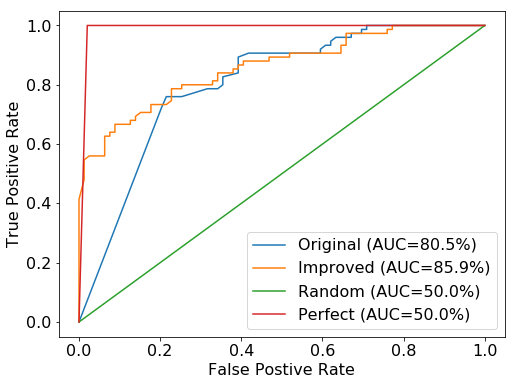

In [39]:
## ROC Curve is very noisy for older model due to segregated sampling (?).
## Better curve is obtained if the model includes all participants/answers
## as in the improved model (not shown)

plt.figure(figsize=(8,6))
auc = roc_auc_score(true_skills, inferred_skills, average='micro')
fpr, tpr, thresholds = roc_curve(true_skills.ravel(), inferred_skills.ravel())
plt.plot(fpr, tpr, label=f'Original (AUC={auc*100:.1f}%)')

auc = roc_auc_score(true_skills, inferred_skills_new, average='micro')
fpr, tpr, thresholds = roc_curve(true_skills.ravel(), inferred_skills_new.ravel())
plt.plot(fpr, tpr, label=f'Improved (AUC={auc*100:.1f}%)')

plt.plot(np.linspace(0,1,50), np.linspace(0,1,50), label=f'Random (AUC=50.0%)')

perfect = np.ones(50)
perfect[0] = 0

plt.plot(np.linspace(0,1,50), perfect, label=f'Perfect (AUC=50.0%)')

plt.ylabel('True Positive Rate')
plt.xlabel('False Postive Rate')
plt.legend();